Drift detected at batch 10. Retraining...
Drift detected at batch 111. Retraining...
Drift detected at batch 273. Retraining...
Drift detected at batch 577. Retraining...
Drift detected at batch 584. Retraining...
Drift detected at batch 588. Retraining...
Drift detected at batch 611. Retraining...
Drift detected at batch 620. Retraining...
Drift detected at batch 809. Retraining...
Drift detected at batch 810. Retraining...

Final Evaluation:
Confusion Matrix:
[[46353  3751]
 [ 3634 46162]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.93      0.93     50104
     Class 1       0.92      0.93      0.93     49796

    accuracy                           0.93     99900
   macro avg       0.93      0.93      0.93     99900
weighted avg       0.93      0.93      0.93     99900



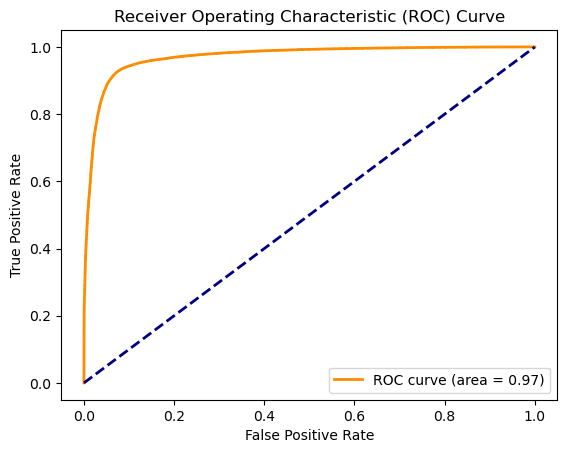

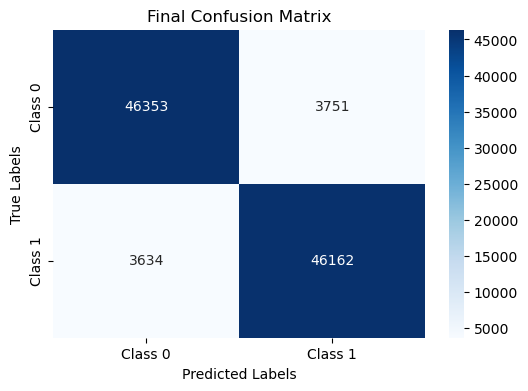

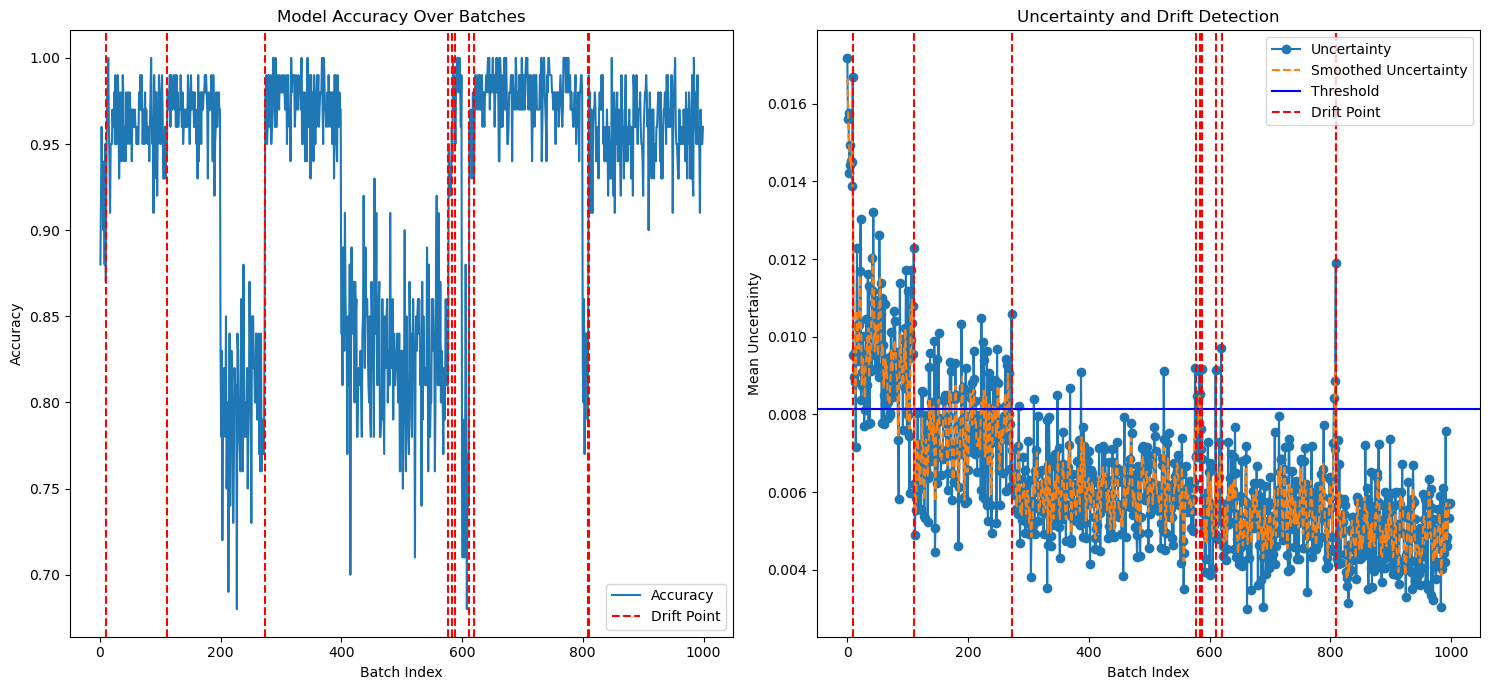

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Load the dataset
file_path = "linear_sudden_rotation_noise_and_redunce.csv"
data = pd.read_csv(file_path)

# Extract features and labels
X_data = torch.tensor(data[["x1", "x2", "x3", "x4", "x5"]].values, dtype=torch.float32)
y_data = torch.tensor(data["label"].values, dtype=torch.float32).view(-1, 1)

# Simulate streaming batches
batch_size = 100
def create_batches(X, y, batch_size):
    return [(X[i:i+batch_size], y[i:i+batch_size]) for i in range(0, len(X), batch_size)]

batches = create_batches(X_data, y_data, batch_size)

# Bayesian Neural Network with Monte Carlo Dropout
class BayesianNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Monte Carlo predictions
def monte_carlo_predictions(model, X, n_samples=50):
    model.train()  # Enable dropout
    preds = torch.stack([model(X) for _ in range(n_samples)])
    mean_pred = preds.mean(dim=0)
    uncertainty = preds.var(dim=0)
    return mean_pred, uncertainty

# Drift detection based on uncertainty
def detect_concept_drift(uncertainty, threshold):
    return uncertainty.mean().item() > threshold

# Training function
def train(model, criterion, optimizer, X_train, y_train, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

# Confusion matrix and metrics function
def evaluate_metrics(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Print classification report
    report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"])
    print("\nClassification Report:")
    print(report)

    return cm, report

# Plot ROC curve
def plot_roc(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

# Initialize the model, criterion, and optimizer
input_size = 5
hidden_size = 10
output_size = 1
model = BayesianNN(input_size, hidden_size, output_size, dropout_rate=0.2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train on the first batch
X_batch, y_batch = batches[0]
train(model, criterion, optimizer, X_batch, y_batch, epochs=50)

# Track uncertainty, predictions, and labels
uncertainties = []
accuracies = []
drift_points = []
batch_indices = []

all_preds = []
all_probs = []
all_true = []

# Process subsequent batches
for i, (X_batch, y_batch) in enumerate(batches[1:], start=1):
    # Monte Carlo predictions
    mean_pred, uncertainty = monte_carlo_predictions(model, X_batch)
    uncertainties.append(uncertainty.mean().item())
    
    # Calculate dynamic threshold
    if i > 1:
        smoothed_uncertainties = uniform_filter1d(uncertainties, size=3)
        threshold = np.mean(smoothed_uncertainties) + np.std(smoothed_uncertainties)
    else:
        threshold = 0.05  # Default threshold for the first batch

    # Detect drift
    if detect_concept_drift(uncertainty, threshold):
        print(f"Drift detected at batch {i}. Retraining...")
        train(model, criterion, optimizer, X_batch, y_batch, epochs=50)
        drift_points.append(i)
    
    # Evaluate performance
    model.eval()
    with torch.no_grad():
        preds_prob = mean_pred.numpy().flatten()  # Prediction probabilities
        preds = (mean_pred > 0.5).float().numpy().flatten()  # Binary predictions
        y_true = y_batch.numpy().flatten()
        
        # Store predictions and true labels for final evaluation
        all_preds.extend(preds)
        all_probs.extend(preds_prob)
        all_true.extend(y_true)

        # Compute batch-wise accuracy
        accuracy = (preds == y_true).mean()
        accuracies.append(accuracy)
        batch_indices.append(i)

# Final evaluation
print("\nFinal Evaluation:")
cm, report = evaluate_metrics(all_true, all_preds)
plot_roc(all_true, all_probs)

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Final Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Final visualization
plt.figure(figsize=(15, 7))

# Accuracy over batches
plt.subplot(1, 2, 1)
plt.plot(batch_indices, accuracies, label="Accuracy")
for point in drift_points:
    plt.axvline(x=point, color='red', linestyle='--', label='Drift Point' if point == drift_points[0] else "")
plt.xlabel("Batch Index")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Batches")
plt.legend()

# Uncertainty visualization
plt.subplot(1, 2, 2)
plt.plot(range(len(uncertainties)), uncertainties, marker='o', label="Uncertainty")
smoothed_uncertainties = uniform_filter1d(uncertainties, size=3)
plt.plot(range(len(smoothed_uncertainties)), smoothed_uncertainties, label="Smoothed Uncertainty", linestyle='--')
plt.axhline(y=threshold, color='blue', linestyle='-', label="Threshold")
for point in drift_points:
    plt.axvline(x=point, color='red', linestyle='--', label='Drift Point' if point == drift_points[0] else "")
plt.xlabel("Batch Index")
plt.ylabel("Mean Uncertainty")
plt.title("Uncertainty and Drift Detection")
plt.legend()

plt.tight_layout()
plt.show()


Drift detected in the following batches: [3, 16, 28, 49, 59, 74, 91, 100, 110, 122, 124, 128, 133, 135, 139, 151, 152, 169, 189, 201, 202, 203, 207, 209, 212, 231, 236, 242, 277, 283, 284, 287, 291, 322, 334, 341, 344, 353, 356, 357, 359, 367, 368, 373, 377, 379, 386, 396, 398, 416, 421, 423, 426, 445, 448, 483, 494, 500, 504, 507, 510, 516, 528, 531, 540, 546, 571, 574, 575, 582, 592, 604, 627, 628, 634, 639, 672, 677, 694, 696, 710, 724, 741, 743, 760, 764, 765, 775, 783, 792, 797, 801, 804, 806, 809, 810, 816, 822, 830, 867, 892, 896, 911, 928, 931, 934, 937, 956, 959, 967, 976, 977, 978, 985, 998]


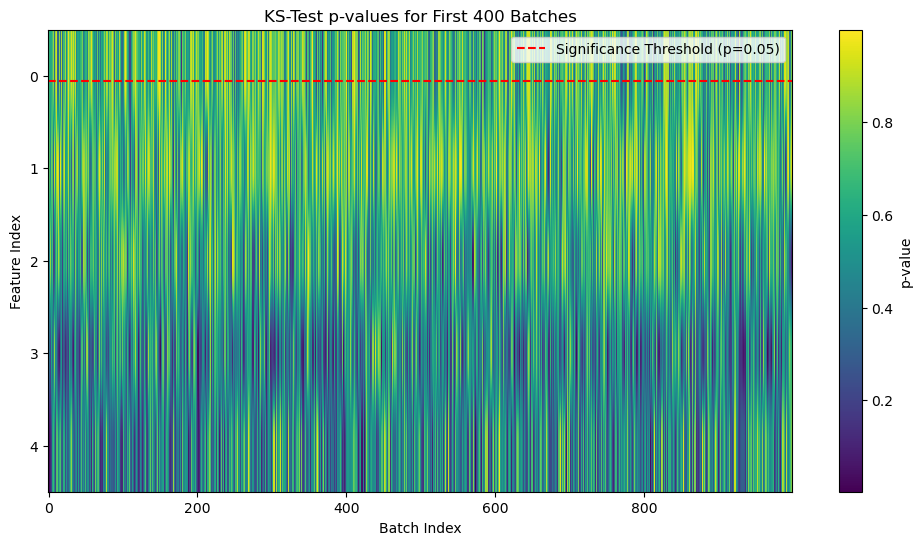

In [9]:
from scipy.stats import ks_2samp
import numpy as np
import matplotlib.pyplot as plt

# Function to apply KS-Test between batches
def ks_test_between_batches(reference_batch, target_batch):
    """
    Perform KS-Test between two batches.
    Args:
        reference_batch: The feature set of the reference batch.
        target_batch: The feature set of the target batch.
    Returns:
        p_values: List of p-values for each feature.
    """
    p_values = []
    for i in range(reference_batch.shape[1]):  # Iterate over each feature
        _, p_value = ks_2samp(reference_batch[:, i], target_batch[:, i])
        p_values.append(p_value)
    return p_values

# Extract first 400 batches
first_400_batches = batches[:]

# Analyze drift in the first 400 batches
reference_batch = first_400_batches[0][0].numpy()  # Use the first batch as the reference
batch_results = []

for i in range(1, len(first_400_batches)):
    target_batch = first_400_batches[i][0].numpy()  # Compare with each subsequent batch
    
    # Perform KS-Test
    p_values = ks_test_between_batches(reference_batch, target_batch)
    batch_results.append((i, p_values))

# Determine if drift exists in each batch (p-value < 0.05 for any feature)
drift_batches = [batch_id for batch_id, p_values in batch_results if any(p < 0.05 for p in p_values)]

# Print results
print(f"Drift detected in the following batches: {drift_batches}")

# Visualize KS-Test p-values
p_values_matrix = np.array([result[1] for result in batch_results])  # Extract all p-values
plt.figure(figsize=(12, 6))
plt.imshow(p_values_matrix.T, cmap='viridis', aspect='auto')
plt.colorbar(label='p-value')
plt.xlabel("Batch Index")
plt.ylabel("Feature Index")
plt.title("KS-Test p-values for First 400 Batches")
plt.axhline(y=0.05, color='red', linestyle='--', label="Significance Threshold (p=0.05)")
plt.legend()
plt.show()


In [10]:
len(drift_batches)

115

In [8]:
len(drift_points)

10